In [0]:
!git clone https://github.com/BriantOliveira/Selfdriving-Simulator

fatal: destination path 'Selfdriving-Simulator' already exists and is not an empty directory.


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

In [0]:
datadir = 'Selfdriving-Simulator/data'
columns = ['center', 'left', 'right', 'steering', 'throttles', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)

In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttles,reverse,speed
0,center_2019_10_15_16_00_54_970.jpg,left_2019_10_15_16_00_54_970.jpg,right_2019_10_15_16_00_54_970.jpg,0.0,0.0,0.0,0.000082
1,center_2019_10_15_16_00_55_073.jpg,left_2019_10_15_16_00_55_073.jpg,right_2019_10_15_16_00_55_073.jpg,0.0,0.0,0.0,0.000079
2,center_2019_10_15_16_00_55_174.jpg,left_2019_10_15_16_00_55_174.jpg,right_2019_10_15_16_00_55_174.jpg,0.0,0.0,0.0,0.000084
3,center_2019_10_15_16_00_55_280.jpg,left_2019_10_15_16_00_55_280.jpg,right_2019_10_15_16_00_55_280.jpg,0.0,0.0,0.0,0.000079
4,center_2019_10_15_16_00_55_390.jpg,left_2019_10_15_16_00_55_390.jpg,right_2019_10_15_16_00_55_390.jpg,0.0,0.0,0.0,0.000082


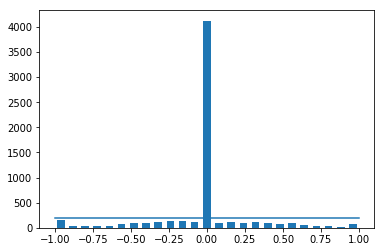

In [0]:
num_bins = 25
sample_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (sample_per_bin, sample_per_bin))

Total data 6100
Removed:  3922
Remaining 2178


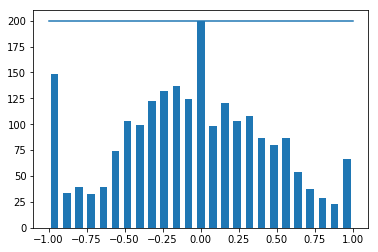

In [0]:
print('Total data', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[sample_per_bin:]
  remove_list.extend(list_)

print('Removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('Remaining', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (sample_per_bin, sample_per_bin))

In [0]:
print(data.iloc[1])
def load_img_steering(datadir,  df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_path, steering

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center       center_2019_10_15_16_00_55_507.jpg
left         left_2019_10_15_16_00_55_507.jpg  
right        right_2019_10_15_16_00_55_507.jpg 
steering     0                                 
throttles    0                                 
reverse      0                                 
speed        7.95367e-05                       
Name: 5, dtype: object


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))

Training Samples: 1742
Valid Samples: 436


Text(0.5, 1.0, 'Validation set')

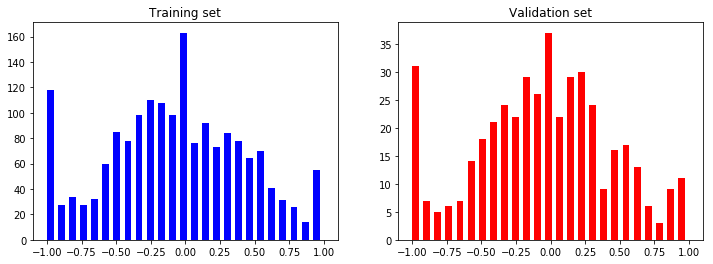

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05,color='blue')
axes[0].set_title("Training set")
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

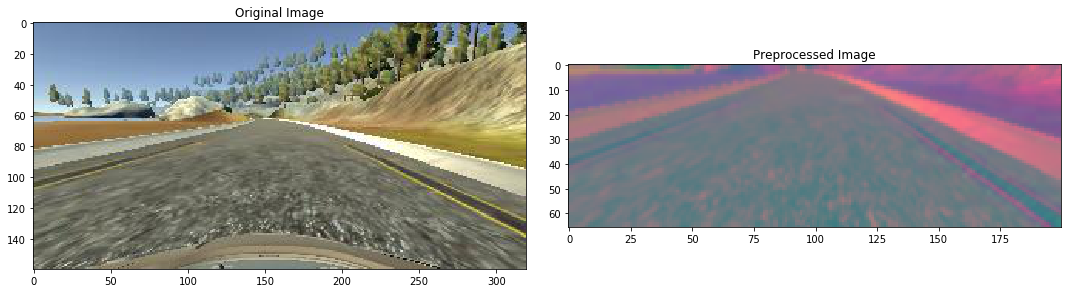

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1742, 66, 200, 3)


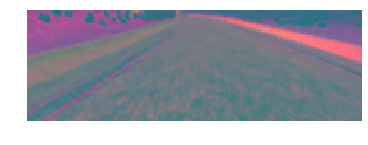

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train) -1)])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Dropout(0.5))

  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))


  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5)) 
  model.add(Dense(1))

  optimizer = Adam(lr= 1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model


In [0]:
model= nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), ac

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
dropout_93 (Dropout)         (None, 5, 22, 48)         0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_94 (Dropout)         (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 1, 18, 64)       

In [0]:
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Train on 1742 samples, validate on 436 samples
Epoch 1/40
1742/1742 [==============================] - 5s 3ms/step - loss: 1.0948 - val_loss: 0.2984
Epoch 2/40
1742/1742 [==============================] - 1s 700us/step - loss: 0.4378 - val_loss: 0.2315
Epoch 3/40
1742/1742 [==============================] - 1s 692us/step - loss: 0.3346 - val_loss: 0.2336
Epoch 4/40
1742/1742 [==============================] - 1s 698us/step - loss: 0.3148 - val_loss: 0.2307
Epoch 5/40
1742/1742 [==============================] - 1s 684us/step - loss: 0.2906 - val_loss: 0.2297
Epoch 6/40
1742/1742 [==============================] - 1s 698us/step - loss: 0.2852 - val_loss: 0.2254
Epoch 7/40
1742/1742 [==============================] - 1s 674us/step - loss: 0.2772 - val_loss: 0.2195
Epoch 8/40
1742/1742 [==============================] - 1s 676us/step - loss: 0.2759 - val_loss: 0.2118
Epoch 9/40
1742/1742 [==============================] - 1s 690us/step - loss: 0.2636 - val_loss: 0.2168
Epoch 10/40
1742/17

Text(0.5, 0, 'Epoch')

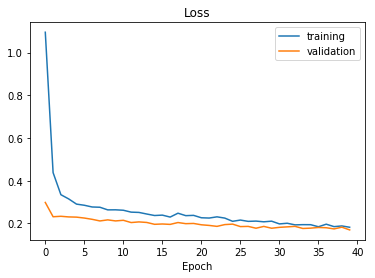

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')